# Multi-domain adversarial Neural Network (MDANN) for GE Data

In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from math import exp
from math import pi
import matplotlib.pyplot as plt

import numpy as np
import pickle as pkl

import tensorflow as tf
from tensorflow.python.framework import ops

from sklearn.datasets import make_moons, make_blobs
from sklearn.decomposition import PCA

Check if GPU is present and if tensorflow sees it.

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 761698476920079569, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6614766059
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4863447228904299343
 physical_device_desc: "device: 0, name: GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"]

Generate synthetic Gaussian blob data for binary classifications. Synthetic "domains" are generated by rotating the two Gaussian blobs through an angle and dilating them.

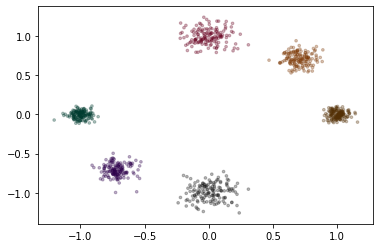

<Figure size 1440x2880 with 0 Axes>

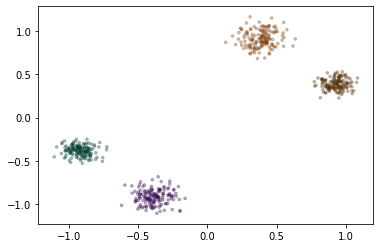

In [3]:
num_domains_train = 3
num_domains_test = 2
num_data = 300

X_train = np.zeros((num_data*num_domains_train, 2))
y_train = np.zeros((num_data*num_domains_train, 2), dtype = int)
D_train = np.zeros((num_data*num_domains_train, num_domains_train), dtype = int)

X_test = np.zeros((num_data*num_domains_test, 2))
y_test = np.zeros((num_data*num_domains_test, 2), dtype = int)

cmap_list = ['BrBG', 'PuOr', 'RdGy']

for i in range(num_domains_train):
    x_blob1 = 1.0*np.cos(i*pi/4.0) #each domain rotated pi/4 degrees, starting at 0
    y_blob1 = 1.0*np.sin(i*pi/4.0)
    x_blob2 = 1.0*np.cos(i*pi/4.0 + pi) #class 1 & class 2 blobs are 180 degree apart
    y_blob2 = 1.0*np.sin(i*pi/4.0 + pi)
    std = 0.05*(0.5*i+1)
    Xs, ys = make_blobs(num_data, centers = [[x_blob1, y_blob1], [x_blob2, y_blob2]], cluster_std = std)
    plt.scatter(Xs[:,0], Xs[:,1], c = ys, cmap = cmap_list[i], s = 7, alpha = 0.3)
    ys = np.eye(2)[ys] #convert to categorical
    X_train[i*num_data: (i+1)*num_data, :] = Xs
    y_train[i*num_data: (i+1)*num_data, :] = ys
    D_train[i*num_data: (i+1)*num_data, i] = 1

plt.figure(figsize=(20, 40))
plt.show()

for i in range(num_domains_test):
    x_blob1 = 1.0*np.cos((i+0.5)*pi/4.0) #each test domain rotated pi/4 degrees, starting at pi/8
    y_blob1 = 1.0*np.sin((i+0.5)*pi/4.0)
    x_blob2 = 1.0*np.cos((i+0.5)*pi/4.0 + pi)
    y_blob2 = 1.0*np.sin((i+0.5)*pi/4.0 + pi)
    std = 0.05*(0.5*(i+0.5)+1)
    Xs, ys = make_blobs(num_data, centers = [[x_blob1, y_blob1], [x_blob2, y_blob2]], cluster_std = std)
    plt.scatter(Xs[:,0], Xs[:,1], c = ys, cmap = cmap_list[i], s = 7, alpha = 0.3)
    ys = np.eye(2)[ys] #convert to categorical
    X_test[i*num_data: (i+1)*num_data, :] = Xs
    y_test[i*num_data: (i+1)*num_data, :] = ys  

plt.show()

Implement gradient reversal layer in TF.

In [4]:
class FlipGradientBuilder(object):
    def __init__(self):
        self.num_calls = 0

    def __call__(self, x, l=1.0):
        grad_name = "FlipGradient%d" % self.num_calls
        @ops.RegisterGradient(grad_name)
        def _flip_gradients(op, grad):
            return [tf.negative(grad) * l]
        
        g = tf.get_default_graph()
        with g.gradient_override_map({"Identity": grad_name}):
            y = tf.identity(x)
            
        self.num_calls += 1
        return y
    
flip_gradient = FlipGradientBuilder()

Set neural network parameter values.

In [5]:
batch_size = 16
x_dim = X_train.shape[1]
hidden_size_f1 = 10
hidden_size_f2 = 10
hidden_size_f3 = 2
hidden_size_l1 = 2
hidden_size_d1 = 5

init_stddev_f1_w = 1.0/np.sqrt(x_dim)
init_stddev_f1_b = init_stddev_f1_w
init_stddev_f2_w = 1.0/np.sqrt(hidden_size_f1)
init_stddev_f2_b = init_stddev_f2_w
init_stddev_f3_w = 1.0/np.sqrt(hidden_size_f2)
init_stddev_f3_b = init_stddev_f3_w
init_stddev_p1_w = 1.0/np.sqrt(hidden_size_f3)
init_stddev_p1_b = init_stddev_p1_w
init_stddev_d1_w = 1.0/np.sqrt(hidden_size_f3)
init_stddev_d1_b = init_stddev_d1_w
init_stddev_d2_w = 1.0/np.sqrt(hidden_size_d1)
init_stddev_d2_b = init_stddev_d2_w

In [13]:
def build_model():
    X = tf.placeholder(tf.float32, [None, x_dim], name='X') # Input data
    Y = tf.placeholder(tf.int32, [None, 2], name='Y')  # Class
    D = tf.placeholder(tf.int32, [None, num_domains_train], name='D')  # Domain
    l = tf.placeholder(tf.float32, [], name='l') # Gradient reversal scaler

    # Feature extractor - three layer
    layer_f1 = tf.layers.Dense(hidden_size_f1, activation = tf.nn.relu,
                               kernel_initializer = tf.random_normal_initializer(mean=0.,stddev=init_stddev_f1_w),
                               bias_initializer = tf.random_normal_initializer(mean=0.,stddev=init_stddev_f1_b),
                               kernel_regularizer = tf.keras.regularizers.l2(l=0.1),
                               bias_regularizer = tf.keras.regularizers.l2(l=0.1))
    F_f1 = layer_f1.apply(X)
    layer_f2 = tf.layers.Dense(hidden_size_f2, activation=tf.nn.relu,
                               kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_f2_w),
                               bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_f2_b),
                               kernel_regularizer = tf.keras.regularizers.l2(l=0.1),
                               bias_regularizer = tf.keras.regularizers.l2(l=0.1))
    F_f2 = layer_f2.apply(F_f1)
    layer_f3 = tf.layers.Dense(hidden_size_f3, activation=tf.nn.relu,
                               kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_f3_w),
                               bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_f3_b),
                               kernel_regularizer = tf.keras.regularizers.l2(l=0.1),
                               bias_regularizer = tf.keras.regularizers.l2(l=0.1))
    F = layer_f3.apply(F_f2) # domain-invariant feature space
    F_ind = tf.identity(F, name = 'feature')

    # Label predictor - single layer

    layer_p1 = tf.layers.Dense(2, activation='linear',
                               kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_p1_w),
                               bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_p1_b))
    p_logit = layer_p1.apply(F)
    p = tf.nn.softmax(p_logit)
    p_loss = tf.nn.softmax_cross_entropy_with_logits(logits = p_logit, labels = Y)

    # Domain predictor - two layer
    f_ = flip_gradient(F, l)

    layer_d1 = tf.layers.Dense(hidden_size_d1, activation=tf.nn.relu,
                               kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_d1_w),
                               bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_d1_b))
    D_d1 = layer_d1.apply(f_)
    layer_d2 = tf.layers.Dense(num_domains_train, activation='linear',
                               kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_d2_w),
                               bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_d2_b))
    d_logit = layer_d2.apply(D_d1)
    d = tf.nn.softmax(d_logit)
    d_loss = tf.nn.softmax_cross_entropy_with_logits(logits=d_logit, labels=D)

    # Optimization
    pred_loss = tf.reduce_sum(p_loss, name='pred_loss')
    domain_loss = tf.reduce_sum(d_loss, name='domain_loss')
    total_loss = tf.add(pred_loss, domain_loss, name='total_loss')
    dann_train_op = tf.train.AdamOptimizer().minimize(total_loss, name='dann_train_op')

    # Evaluation
    p_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y, 1), tf.argmax(p, 1)), tf.float32), name='p_acc')
    d_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(D, 1), tf.argmax(d, 1)), tf.float32), name='d_acc')

In [14]:
build_model()
sess = tf.InteractiveSession()